In [2]:
import numpy as np
from matplotlib import pyplot as plt
import struct

# MNIST digit set:
FILE_DIGIT_TRAIN_IMG = 'MNIST/train-images-idx3-ubyte'
FILE_DIGIT_TRAIN_LBL = 'MNIST/train-labels-idx1-ubyte'
FILE_DIGIT_TEST_IMG = 'MNIST/t10k-images-idx3-ubyte'
FILE_DIGIT_TEST_LBL = 'MNIST/t10k-labels-idx1-ubyte'

# MNIST fasion set:
# 0 T-shirt/top 1 Trouser
# 2 Pullover    3 Dress
# 4 Coat        5 Sandal
# 6 Shirt       7 Sneaker
# 8 Bag         9 Ankle boot
FILE_FASHION_TRAIN_IMG = 'MNIST-FASHION/train-images-idx3-ubyte'
FILE_FASHION_TRAIN_LBL = 'MNIST-FASHION/train-labels-idx1-ubyte'
FILE_FASHION_TEST_IMG = 'MNIST-FASHION/t10k-images-idx3-ubyte'
FILE_FASHION_TEST_LBL = 'MNIST-FASHION/t10k-labels-idx1-ubyte'

FILE_TRAIN_IMG = FILE_DIGIT_TRAIN_IMG
FILE_TRAIN_LBL = FILE_DIGIT_TRAIN_LBL
FILE_TEST_IMG = FILE_DIGIT_TEST_IMG
FILE_TEST_LBL = FILE_DIGIT_TEST_LBL

# open the training file
with open(FILE_TRAIN_IMG, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_data = train_data.reshape((size, nrows * ncols))
    # m, n = data.shape # m: num of rows n: num of pixels
    train_data = train_data.T
    train_data = train_data / 255

# open the label file for validation
with open(FILE_TRAIN_LBL,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

# open the testing file
with open(FILE_TEST_IMG, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_data = test_data.reshape((size, nrows * ncols))
    test_data = test_data.T
    test_data = test_data / 255

# open the testing label file for validation
with open(FILE_TEST_LBL,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


In [3]:
# layer 0: input layer: X
#   784 nodes - 1 per pixel
# layer 1: hidden layer: W1
#   10 nodes - 1 per digit
# layer 2: output layer: A2
#   10 nodes - 1 per digit

# Training the network
# 1) Forward propagation
#   A[0] = x; // pass an image through the network and compute output
#   Z[1] = W[1]A[0] + b[1]; // multiply by a weight and add a constant bias
#   activation function - w/o this step, each node would just be a linear combination of the previous nodes
#   tansh or sigmoid function are common activation functions - but we'll use relu
#   relu - rectified linear unit - g(x) = x > 0 ? x : 0;
#   A[1] = relu(Z[1])
#   another activation function for our 2nd layer
#   softmax - pick the best of our options for the output layer
#   softmax(node z) = (e^z) / (sum(e^z)); // weight of current node divided by the total weight of all nodes

# generate random arrays of floats for initial weights and biases
# floats generated have a uniform distribution
# subtract 0.5 to normalize over -0.5 - 0.5
def init_params_uniform():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

# generate random arrays of floats for initial weights and biases
# floats generated have a uniform distribution
#   loc:   the mean of the data
#   scale: the standard deviation of the data
def init_params_normal(loc:float, scale:float):
    rng = np.random.default_rng()
    W1 = rng.normal(loc, scale, (10, 784))
    b1 = rng.normal(loc, scale, (10, 1))
    W2 = rng.normal(loc, scale, (10, 10))
    b2 = rng.normal(loc, scale, (10, 1))
    return W1, b1, W2, b2

# Activation function (1st layer): REctified Linear Unit
def relu(Z1):
    return np.maximum(Z1, 0)

# Derivative of our activation function
def relu_deriv(Z1):
    return Z1 > 0

# Activation function (2nd layer):
def softmax(Z2):
    return np.exp(Z2) / sum(np.exp(Z2))

# run an image through the network and get output
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# "one-hot encoding" create a 1xm matrix with only one "bit" flipped
# Y will be our labels matrix
def one_hot(Y):
    oh = np.zeros((Y.size, 10), dtype=np.int8)
    oh[np.arange(Y.size), Y] = 1
    return oh.T

# 2) Backwards propagation
#   find the error across layers
#   let dZ[1] be the error of the 1st layer
#   let dZ[2] be the error of the 2nd layer
#   dZ[2] = A - Y
#   dW[2] = 1/m * dZ[2]A[1]T
#   db[2] = 1/m * sum(dz[2])
#   dZ[1] = W[2]T * dZ[2] .* g'(Z[0]) // g' is the derivative of the activation function g(x)
#   dW[1] = 1/m * dZ[1] * XT
#   db[1] = 1/m * sum(dZ[1])

# run an image "backwards" through the network to calculate error
# size: the number of elements in the sample
def backward_prop(Z1, A1, A2, W2, X, Y, size):
    dZ2 = A2 - one_hot(Y)
    dW2 = 1/size * dZ2.dot(A1.T)
    db2 = 1/size * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * relu_deriv(Z1)
    dW1 = 1/size * dZ1.dot(X.T)
    db1 = 1/size * np.sum(dZ1)
    return dW1, db1, dW2, db2

# 3) Update parameters
#   W[1] = W[1] - alpha * dW[1]
#   b[1] = b[1] - alpha * db[1]
#   w[2] = W[2] - alpha * dW[2]
#   b[2] = b[2] - alpha * db[2]
#   where alpha is some learning rate. this is a parameter you set, not gradient descent
#   .2 is our best alpha for digits and .1 for fashion

# change our parameters based on learning rate alpha
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

# isolate the index of the most likely guess
def get_predictions(A2):
    return np.argmax(A2, 0)

# given some weights/biases and data set X,
# run the network and record the results
def make_predictions(W1, b1, W2, b2, X):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

# given some predictions and correct labels, check % correct
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

# the fun part
def gradient_descent(W1, b1, W2, b2, X, Y, alpha, iterations):
    """X: our training data
    Y: the labels for the data
    alpha: learning rate
    iterations: number of iterations"""
    num_examples = X[0].size
    acc = [] # list to store intermediate results
    for i in range(iterations): # main training loop
        Z1, A1, _, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, A2, W2, X, Y, num_examples)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % (iterations // 4) == 0:
            print("Iteration: ", i)
            a = get_accuracy(get_predictions(A2), Y)
            acc.append(a)
            print(a)
    print("Training complete.")
    a = get_accuracy(get_predictions(A2), Y)
    acc.append(a)
    print(a)
    return W1, b1, W2, b2, acc

# compare against a test set Y
# Run the NN on a harder set of images it has never seen before
def test(W1, b1, W2, b2, X, Y):
    print("Testing complete.")
    a = get_accuracy(make_predictions(W1, b1, W2, b2, X), Y)
    print(a, "final accuracy.")
    return a

# compare against a specific case index in set Y
def test_prediction(index, W1, b1, W2, b2, X, Y):
    current_image = X[:, index, None]
    prediction = make_predictions(W1, b1, W2, b2, current_image)
    label = Y[index]
    print("Prediction:", prediction)
    print("Label:", label)
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


In [5]:
W1, b1, W2, b2 = init_params_normal(0.0, 0.045)
W1, b1, W2, b2, _ = gradient_descent(W1, b1, W2, b2, train_data, train_labels, 2/3, 125)

a = test(W1, b1, W2, b2, test_data, test_labels)

# An really tough one it tends to fail (MNIST test 8 FASHION test 344)
# test_prediction(344, W1, b1, W2, b2, test_data, test_labels)


Iteration:  0
[2 2 2 ... 2 2 2] [5 0 4 ... 5 6 8]
0.10543333333333334
Iteration:  31
[0 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
0.5376166666666666
Iteration:  62
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.76955
Iteration:  93
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.8729166666666667
Iteration:  124
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9016666666666666
Training complete.
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
0.9016666666666666
Testing complete.
[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]
0.903 final accuracy.


In [82]:
import time
import csv

# digit parameters: init_params_normal(0.0, 0.045)
#                   alpha=0.66667       250 epochs
def hyperparameter_test(of, iterations=500):
    if of.closed:
        return
    print("Beginning hyperparameter test with", iterations, "iterations/test")
    tic = time.perf_counter()
    csvout = csv.writer(of)
    csvout.writerow(["loc", "scale", "alpha", "Epoch 1/4", "Epoch 2/4", "Epoch 3/4", "Epoch 4/4", "Test"])
    for alpha in np.linspace(0.4, 1, 10):
        loc = 0.0
        scale = 0.045
        print("Starting test with (loc, scale, alpha):", loc, scale, alpha)
        W1, b1, W2, b2 = init_params_normal(loc, scale)
        W1, b1, W2, b2, acc = gradient_descent(W1, b1, W2, b2, train_data, train_labels, alpha, iterations)
        accT = test(W1, b1, W2, b2, test_data, test_labels)
        print("Test accuracy", accT)
        data = [loc, scale, alpha, acc[1], acc[2], acc[3], acc[4], accT]
        csvout.writerow(data)
    toc = time.perf_counter()
    print(f"Test complete in {toc - tic:0.1f} seconds.")

def operate(fname='output.csv'):
    # open the test results from csv format
    with open(fname) as f:
        # data order is loc, scale, E1, E2, E3, E4, test
        data = np.genfromtxt(f, delimiter=',', skip_header=1)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    cidx = 0
    for row in data:
        x = []
        y = []
        labels = []
        color_list = []
        labels.append('alpha: {:3f}'.format(row[2]))
        for idx in range(1, 6):
            x.append(idx)
            y.append(row[idx + 2])
            color_list.append(colors[cidx])
        cidx = (cidx + 1) % len(colors)
        plt.scatter(x, y, c=color_list, label=labels)
    plt.title("hyperparameter test results")
    plt.xlabel("Epoch 1/4 - 2/4 - 3/4 - 4/4 - test")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

# with open('output.csv', 'w', newline='') as newfile:
#     hyperparameter_test(newfile, 500)


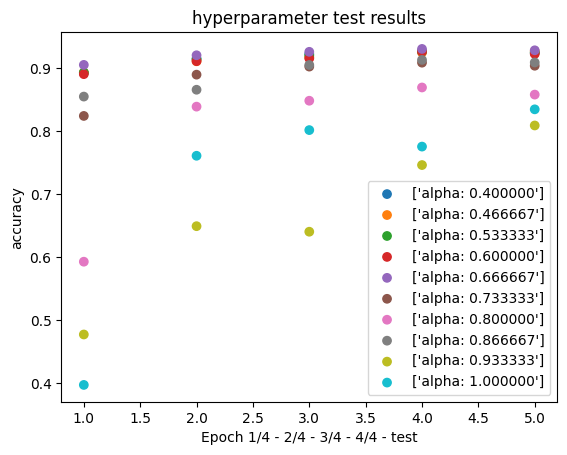

In [83]:
operate()

# # change our pixels using error rather than parameters
# def update_pixels(pixels, dpixels, alpha):
#     pixels = pixels + alpha * dpixels
#     return pixels

# # visualize the model
# # use gradient descent to coax noise into an "ideal" digit
# def visualize(W1, b1, W2, b2, digit, alpha, iterations):
#     pixels = np.random.rand(784, 10)
#     Y = np.full(1, digit, dtype=np.int8)
#     for _ in range(iterations):
#         Z1, A1, _, A2 = forward_prop(W1, b1, W2, b2, pixels)
#         dpixels, _, _, _ = backward_prop(Z1, A1, A2, W2, pixels, Y, 1)
#         pixels = update_pixels(pixels, dpixels.T, alpha)

#         # if i % (iterations // 20) == 0:
#         #     img = pixels.reshape((28, 28)) * 255
#         #     plt.gray()
#         #     plt.imshow(img, interpolation='nearest')
#         #     plt.show()
#     img = pixels[:, digit].reshape((28, 28)) * 255
#     plt.gray()
#     plt.imshow(img, interpolation='nearest')
#     plt.show()
#     return pixels
